In [2]:
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(annotate)
library(stringr)
library(XML)
library(qqman)

ERROR: Error in library(GenomicRanges): there is no package called ‘GenomicRanges’


In [2]:
data <- read.csv(file='vst_results.csv')
data$chr <- sub("^", "chr", data$chr)

data$X <- NULL
data

chr,start,end,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,SouthAsia.Africa,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,228416,267160,-0.00859,-0.00031,0.01591,0.01830,-0.00710,-0.00845,-0.00453,⋯,-0.00421,0.05935,-0.01957,-0.00104,0.10048,-0.01725,0.02036,0.04087,0.01628,-0.00876
chr1,471226,471326,-0.00317,0.07340,-0.01538,-0.00504,0.03033,-0.00861,0.10297,⋯,0.02418,0.13745,0.00954,0.06342,-0.01186,0.00566,-0.01710,0.07967,-0.00458,0.02552
chr1,712534,763301,-0.00387,0.03788,0.00408,0.00332,0.03174,-0.00574,0.07346,⋯,0.00359,-0.01710,-0.01245,0.04324,-0.01917,0.00852,0.01138,-0.01817,0.01257,0.03595
chr1,763301,763482,-0.00613,0.00000,0.00556,0.00000,0.00000,0.00499,0.00859,⋯,0.02413,NA,NA,0.02235,0.01853,0.01771,-0.01426,NA,0.01583,0.01496
chr1,769541,787076,-0.00871,-0.00897,-0.01210,0.00271,-0.00977,-0.00618,-0.01130,⋯,-0.01430,0.00000,-0.00962,-0.00797,0.00000,-0.01480,-0.01490,0.00000,0.00784,-0.01547
chr1,787076,787479,0.00913,NA,0.00000,NA,NA,0.01394,0.00743,⋯,0.00000,NA,NA,0.01111,0.00000,0.00000,-0.01490,NA,0.00784,0.00741
chr1,795270,797682,-0.00645,0.00000,-0.00634,-0.00675,-0.00675,0.02004,-0.00022,⋯,0.00000,0.00000,0.00000,0.02173,-0.02039,-0.02127,-0.00979,-0.02272,-0.01096,-0.01276
chr1,810543,811145,-0.00816,-0.00343,-0.00840,-0.00991,0.00000,0.00261,-0.00745,⋯,-0.00975,-0.00798,0.00000,-0.01032,-0.01947,0.00000,-0.01489,0.00000,-0.01316,0.00741
chr1,811145,812525,-0.00802,-0.00343,-0.00840,0.00000,-0.00928,-0.00618,-0.00749,⋯,-0.00975,0.00000,-0.00980,-0.00885,0.00000,-0.02118,-0.01378,0.00000,0.00000,-0.01448


In [3]:
coordinates <- data[, c(1,2,3)]
names(coordinates) <- c("Chromosome", "Start", "End")

In [4]:
intervals = GenomicRanges::makeGRangesFromDataFrame(coordinates)
txdb = TxDb.Hsapiens.UCSC.hg19.knownGene

In [5]:
intervals

GRanges object with 8650 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1       228416-267160      *
     [2]     chr1       471226-471326      *
     [3]     chr1       712534-763301      *
     [4]     chr1       763301-763482      *
     [5]     chr1       769541-787076      *
     ...      ...                 ...    ...
  [8646]     chrX 154776475-154788811      *
  [8647]     chrX 154788811-154840186      *
  [8648]     chrX 154789310-154826421      *
  [8649]     chrX 154892549-154908191      *
  [8650]     chrX 154908191-154948137      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [6]:
#Gene ids 
genes = genes(txdb)

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [7]:
# Annotating function
annotateIntervals <-
    function(intervals, txdb)
{
    stopifnot(is(intervals, "GRanges"), is(txdb, "TxDb"))
    anno = genes(txdb)
    olaps = findOverlaps(intervals, anno)
    mcols(olaps)$gene_id = genes$gene_id[subjectHits(olaps)]
    intervals_factor = factor(queryHits(olaps), levels=seq_len(queryLength(olaps)))
    intervals$gene_id = splitAsList(mcols(olaps)$gene_id, intervals_factor)
    intervals
}     

In [8]:
myAnnotation <- as.data.frame(annotateIntervals(intervals, txdb))
myDf_master <- data.frame()


  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [9]:
for (i in 1:length(myAnnotation$gene_id)) {
  if(length(c(na.omit(myAnnotation$gene_id[i])[[1]])) != 0) {
  myDf <- data.frame(myAnnotation$seqnames[i], myAnnotation$start[i], 
    myAnnotation$end[i], toString(unname(getSYMBOL(c(na.omit(myAnnotation$gene_id[i])[[1]]), data='org.Hs.eg'))))
  myDf_master <- rbind(myDf_master, myDf)
 }
}


In [10]:
myDf_header <- c("chr", "start", "end", "genes")
names(myDf_master) <- myDf_header


In [11]:
df_merge <- merge(myDf_master,data,by=c("chr", "start","end"))


In [12]:
df_merge$chr <- gsub("chr","",as.character(df_merge$chr))

write.csv(df_merge,"vst_gene_anotation.csv", row.names = FALSE)


### Changing X chromosome to 23 for manhattan plot 
df_merge$chr <- as.integer(df_merge$chr)
df_merge$chr[is.na(df_merge$chr)] <- 23
df_merge

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


chr,start,end,genes,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100517299,100523294,MFSD14A,0.00000,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,10067509,10076124,RBP7,NA,0.03192,NA,NA,NA,NA,⋯,0.01971,0.01833,0.01734,0.02624,NA,NA,NA,NA,NA,NA
1,1009660,1015541,RNF223,-0.00868,0.00113,0.01764,-0.00722,0.04280,-0.00845,⋯,-0.00567,-0.01392,0.02035,-0.00430,-0.00206,-0.00876,0.01326,0.03724,-0.01209,0.04396
1,102395735,102403958,OLFM3,0.00481,-0.00842,0.00373,0.00342,0.00320,0.00534,⋯,0.00000,0.00000,0.00000,0.00000,NA,NA,NA,NA,NA,NA
1,10272327,10278119,KIF1B,NA,0.00000,NA,0.00000,NA,NA,⋯,0.00000,-0.01123,0.00000,0.00000,0.00000,NA,NA,0.00000,0.00000,NA
1,10282248,10326922,KIF1B,NA,0.00000,NA,NA,NA,NA,⋯,0.00000,0.00000,0.00000,0.00000,NA,NA,NA,NA,NA,NA
1,1051484,1053875,C1orf159,0.00425,-0.00094,-0.00089,-0.00573,-0.01108,-0.00815,⋯,0.01829,-0.01603,-0.01343,-0.00467,0.01360,-0.00442,-0.00048,-0.01962,-0.01033,-0.01636
1,10630864,10650632,PEX14,-0.00671,0.00000,0.00000,0.00000,0.00000,0.12435,⋯,NA,NA,NA,0.10997,NA,NA,0.08569,NA,0.07997,0.07584
1,107891259,107899854,NTNG1,0.00383,0.00414,0.00016,0.00272,0.00255,-0.00900,⋯,0.02451,NA,NA,0.00000,0.01883,0.01799,-0.00233,NA,0.00000,0.00000


In [13]:
#Input for Manhattan plot
SNP <- df_merge$genes
CHR <- df_merge$chr
BP <- df_merge$start
P <- df_merge$Africa.America
df <- data.frame(SNP,CHR,BP,P)
df$P[is.na(df$P)] <- 0

df

SNP,CHR,BP,P
<chr>,<dbl>,<int>,<dbl>
MFSD14A,1,100517299,0.00000
RBP7,1,10067509,0.01734
RNF223,1,1009660,0.02035
OLFM3,1,102395735,0.00000
KIF1B,1,10272327,0.00000
KIF1B,1,10282248,0.00000
C1orf159,1,1051484,-0.01343
PEX14,1,10630864,0.00000
NTNG1,1,107891259,0.00000


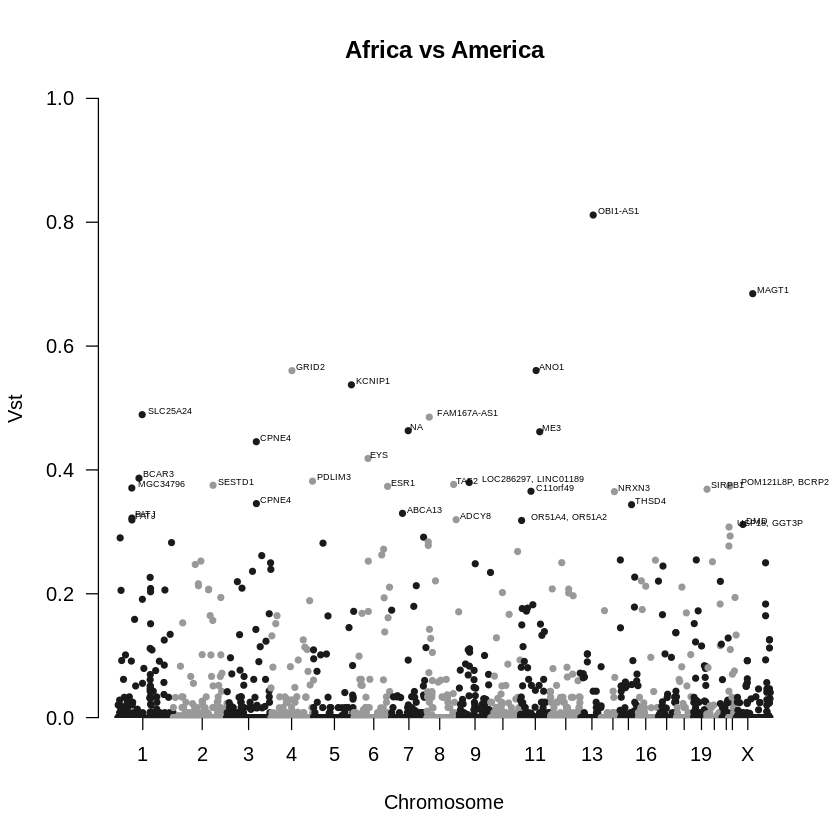

In [14]:
manhattan(df, logp = FALSE, annotatePval= 0.30,  annotateTop = FALSE, ylab="Vst", main='Africa vs America', chrlabs= c(1:22,"X"))

<h1> Manhattan plot for each group

In [15]:
SNP <- df_merge$genes
CHR <- as.integer(df_merge$chr)
BP <- df_merge$start
#P <- df_merge$WestEurasia.Oceania

coordinates <- data.frame(SNP,CHR,BP)
coordinates$CHR[is.na(coordinates$CHR)] <- "X"
coordinates


SNP,CHR,BP
<chr>,<chr>,<int>
MFSD14A,1,100517299
RBP7,1,10067509
RNF223,1,1009660
OLFM3,1,102395735
KIF1B,1,10272327
KIF1B,1,10282248
C1orf159,1,1051484
PEX14,1,10630864
NTNG1,1,107891259


In [16]:
names(df_merge[5:25])

[1] "WestEurasia.SouthAsia"          "WestEurasia.Africa"            
 [3] "WestEurasia.CentralAsiaSiberia" "WestEurasia.Oceania"           
 [5] "WestEurasia.America"            "WestEurasia.EastAsia"          
 [7] "SouthAsia.Africa"               "SouthAsia.CentralAsiaSiberia"  
 [9] "SouthAsia.Oceania"              "SouthAsia.America"             
[11] "SouthAsia.EastAsia"             "Africa.CentralAsiaSiberia"     
[13] "Africa.Oceania"                 "Africa.America"                
[15] "Africa.EastAsia"                "CentralAsiaSiberia.Oceania"    
[17] "CentralAsiaSiberia.America"     "CentralAsiaSiberia.EastAsia"   
[19] "Oceania.America"                "Oceania.EastAsia"              
[21] "America.EastAsia"

In [17]:
## SAVING PLOTS 
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  png(file=paste0("manhattan_plots/",names(df_merge[5:25])[i],".png"))  #+names(df_merge[5:25])[i]+
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst", chrlabs= c(1:22,"X"))
  dev.off() 

}

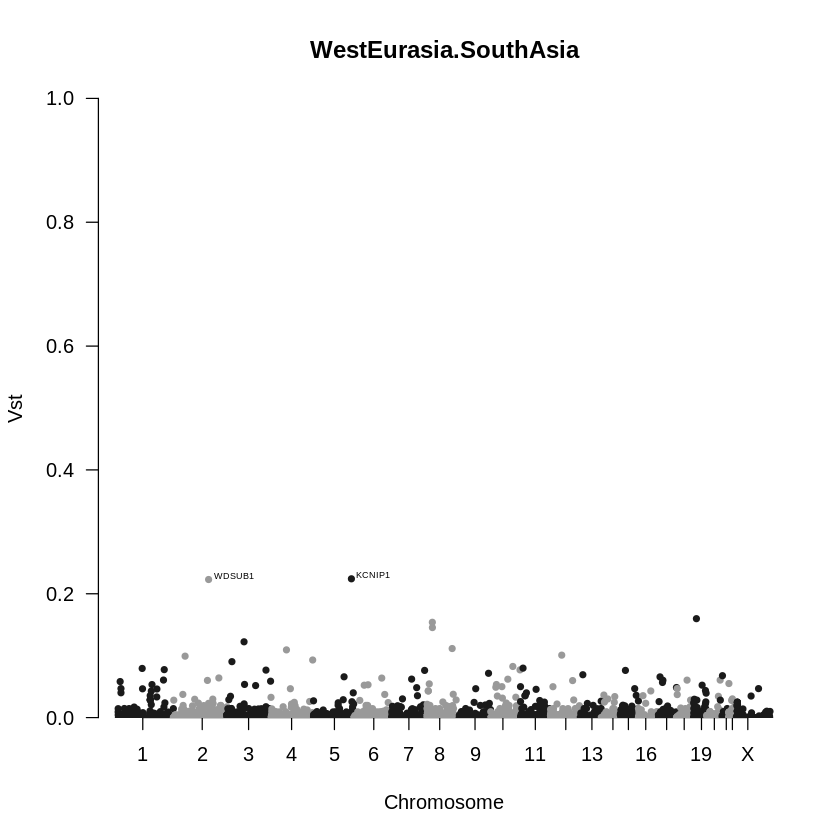

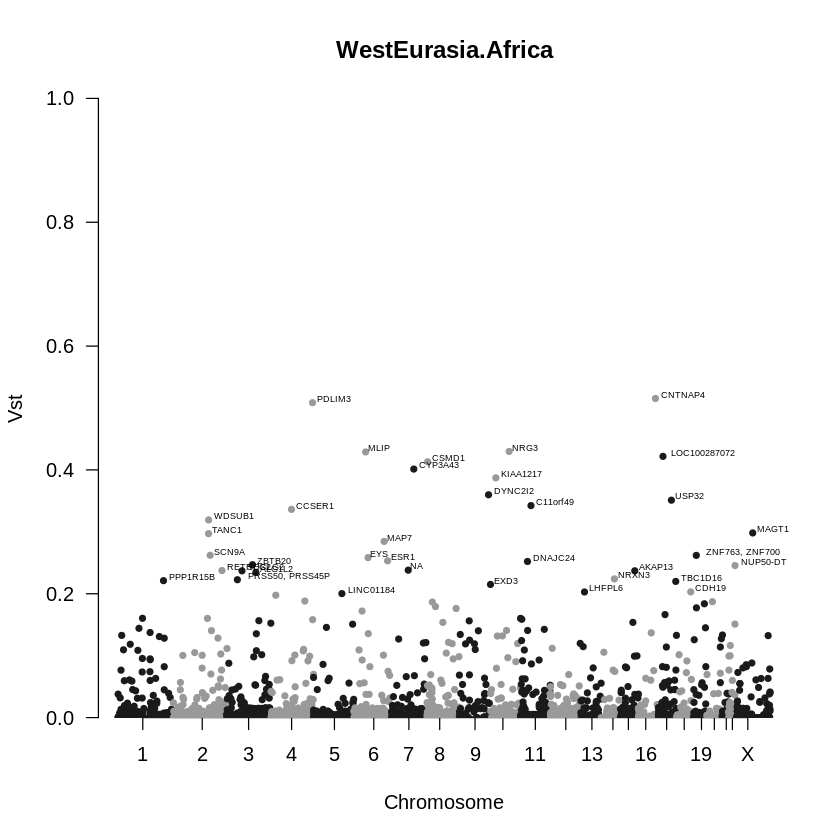

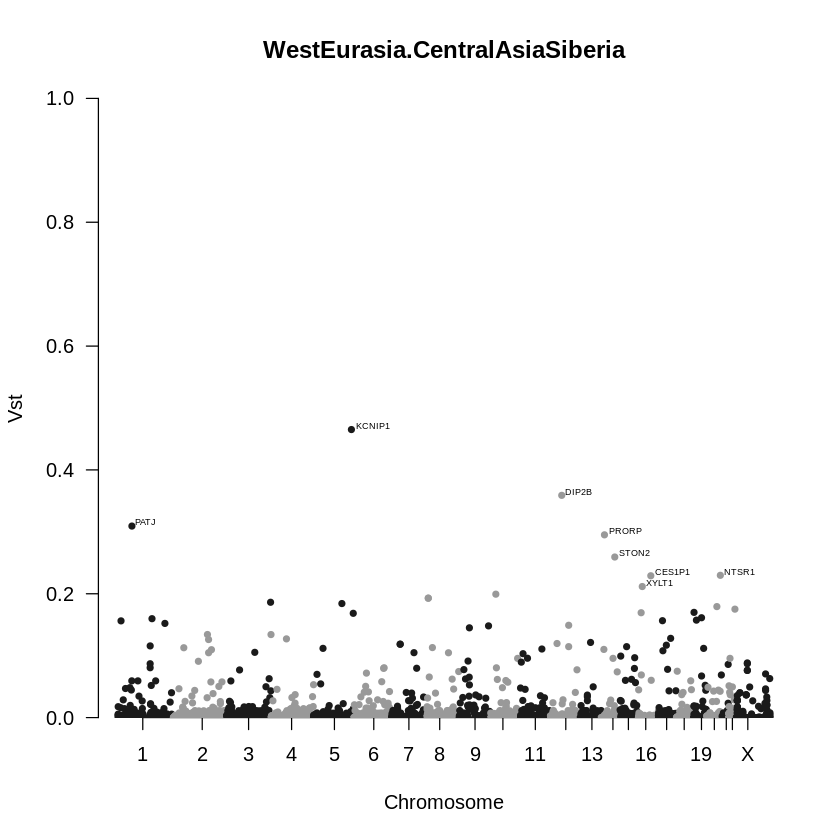

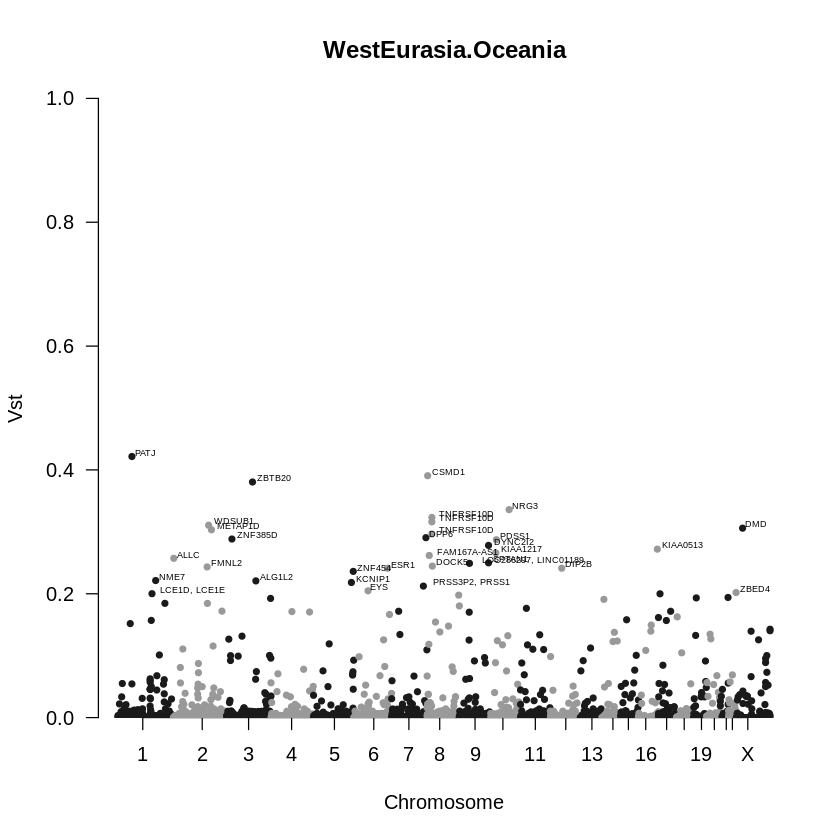

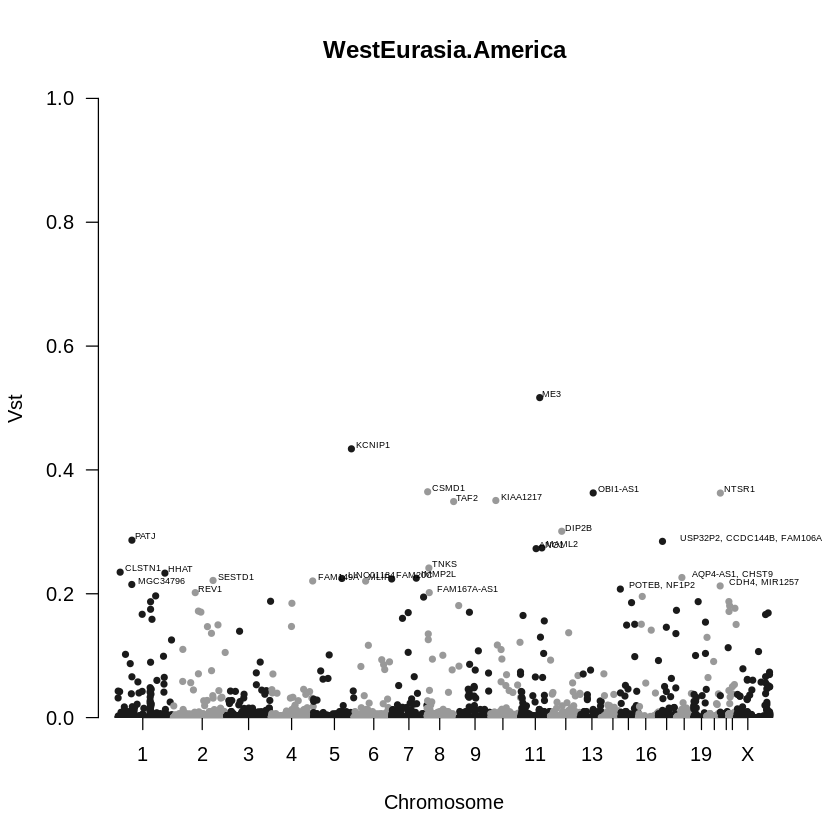

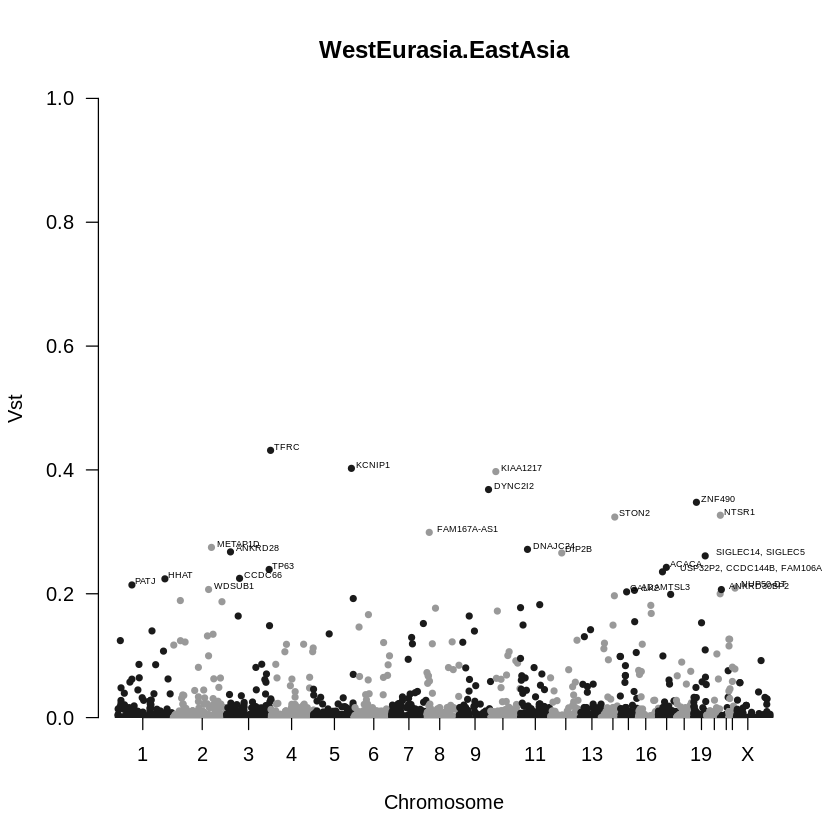

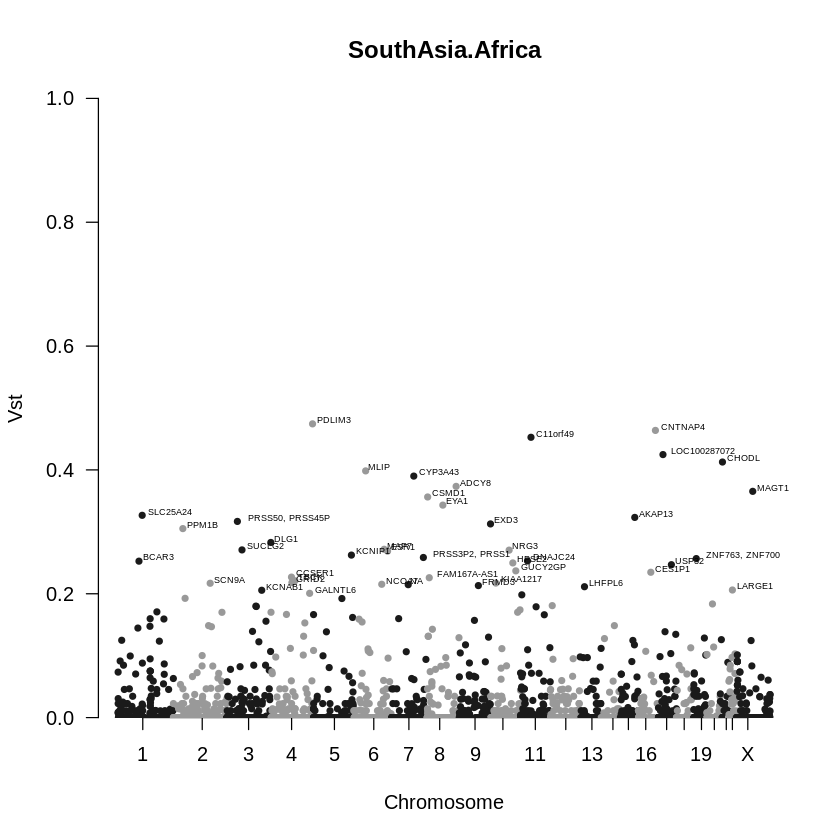

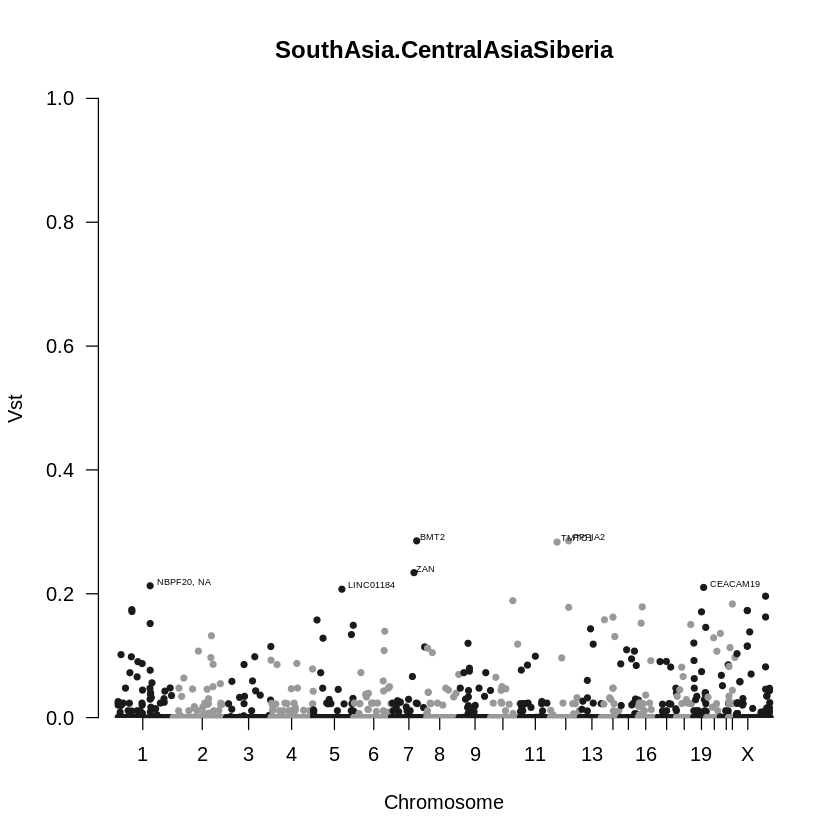

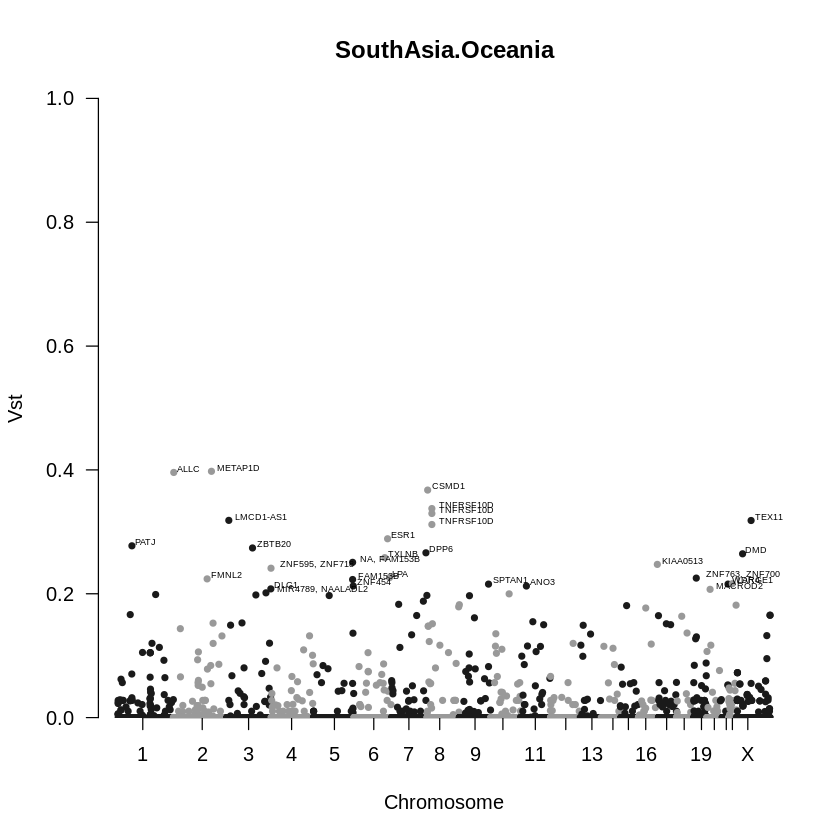

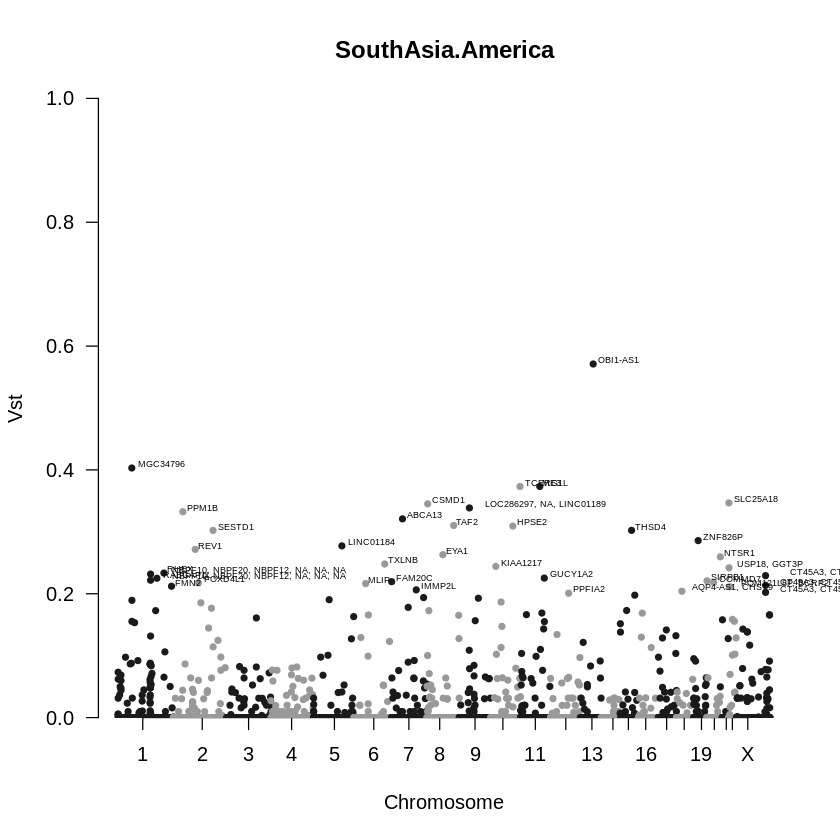

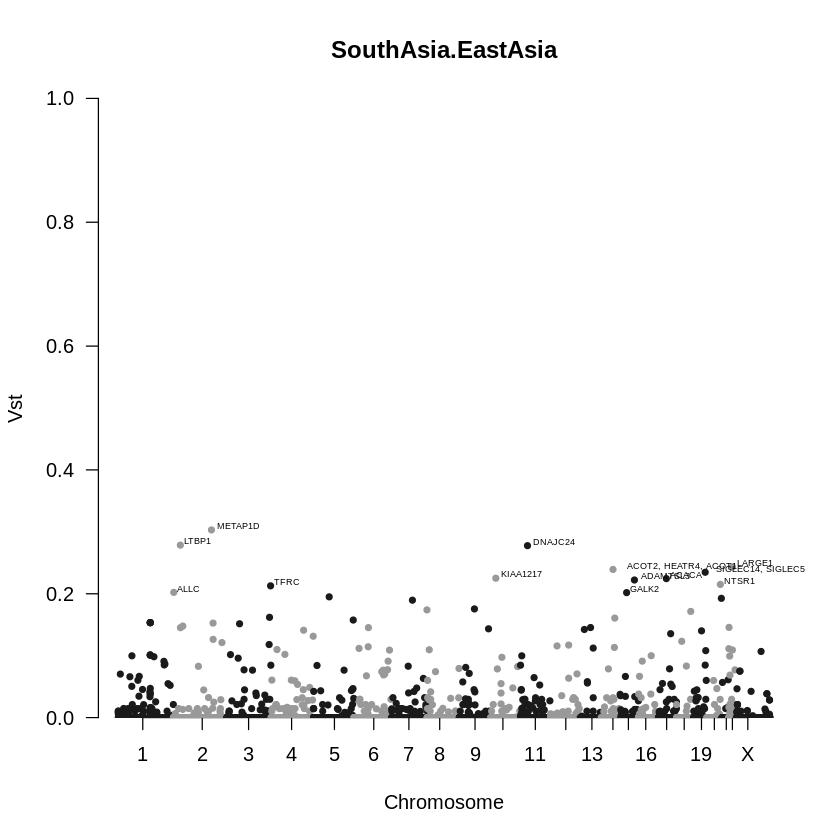

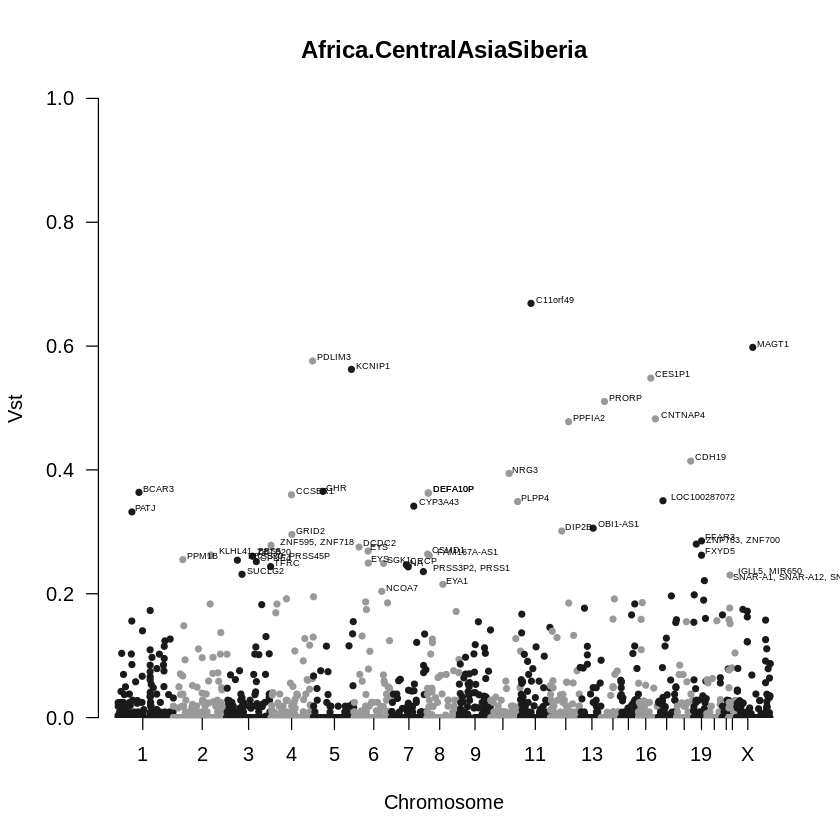

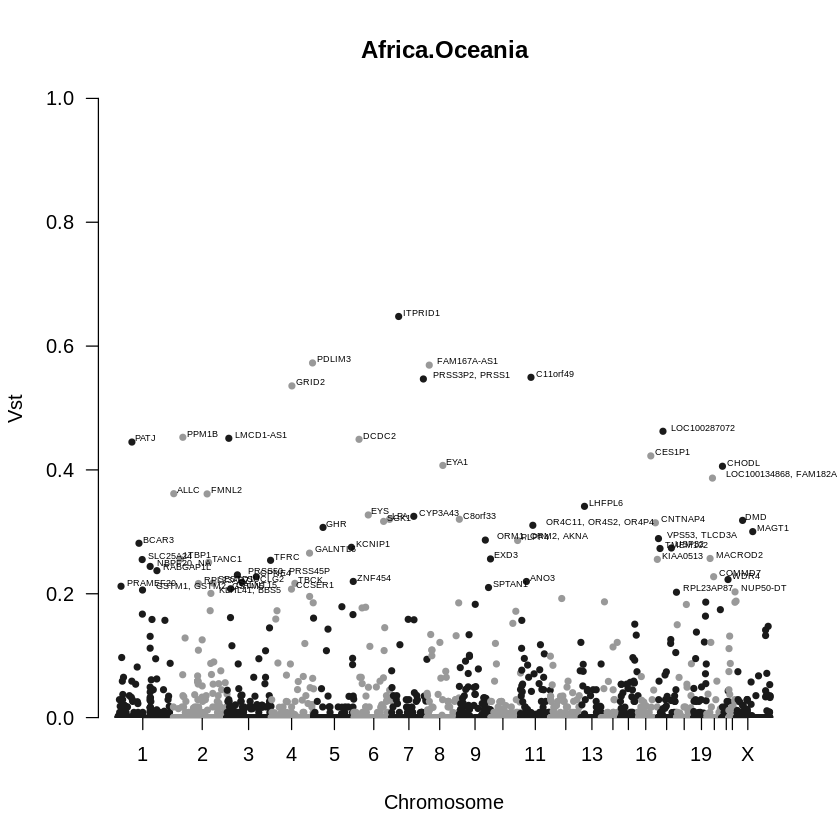

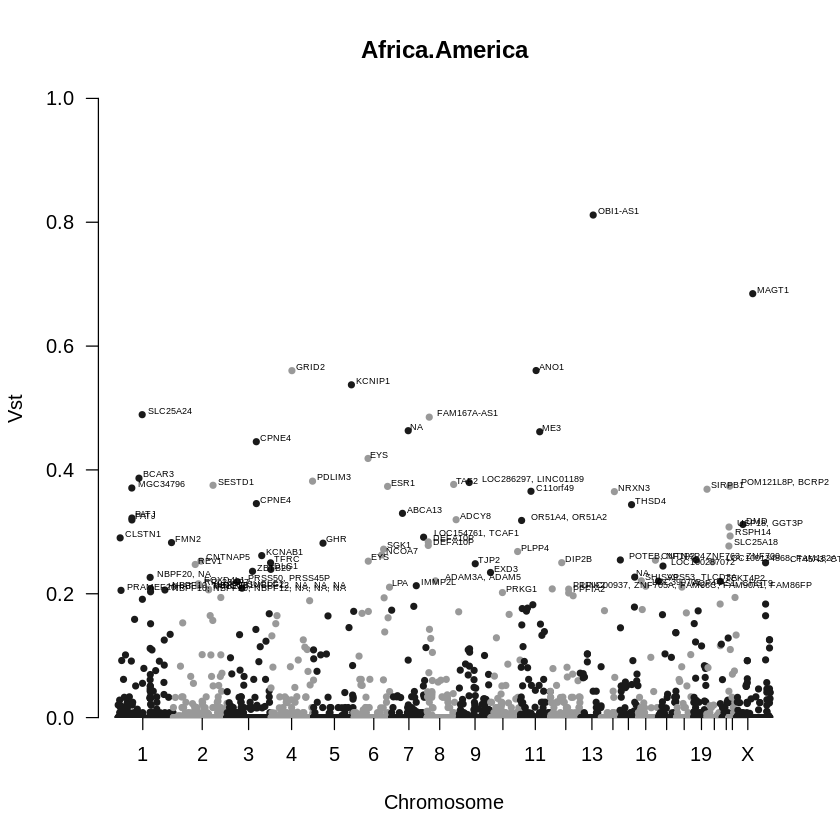

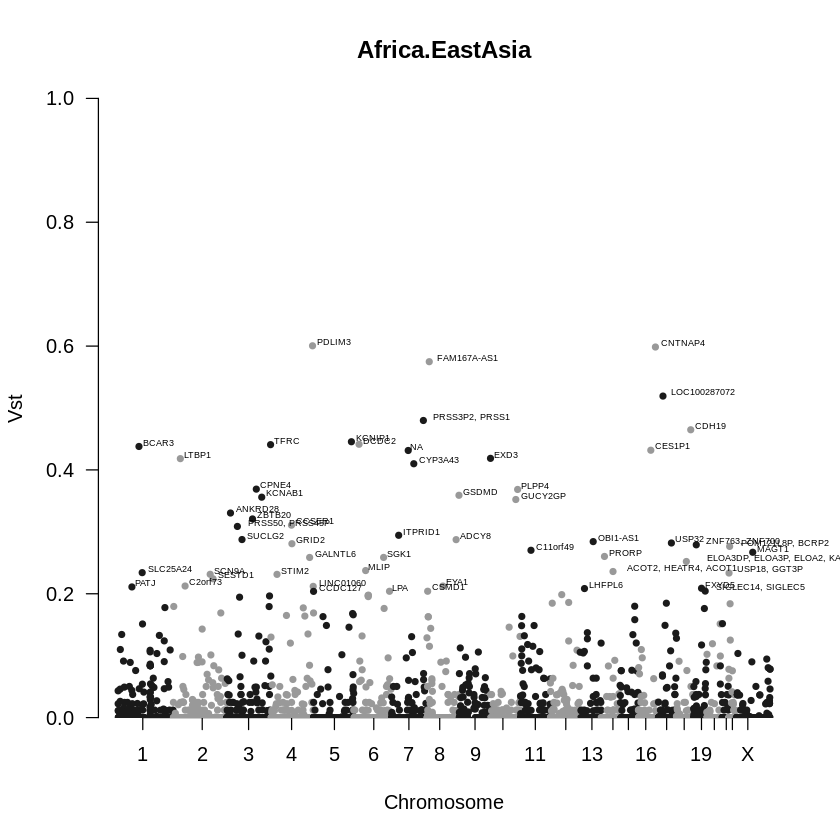

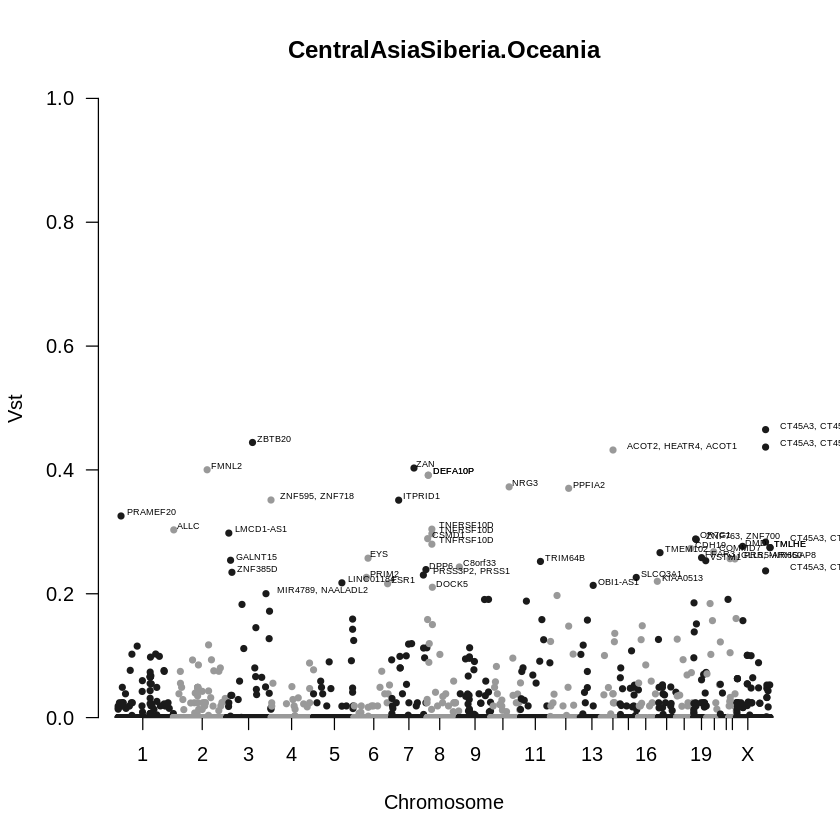

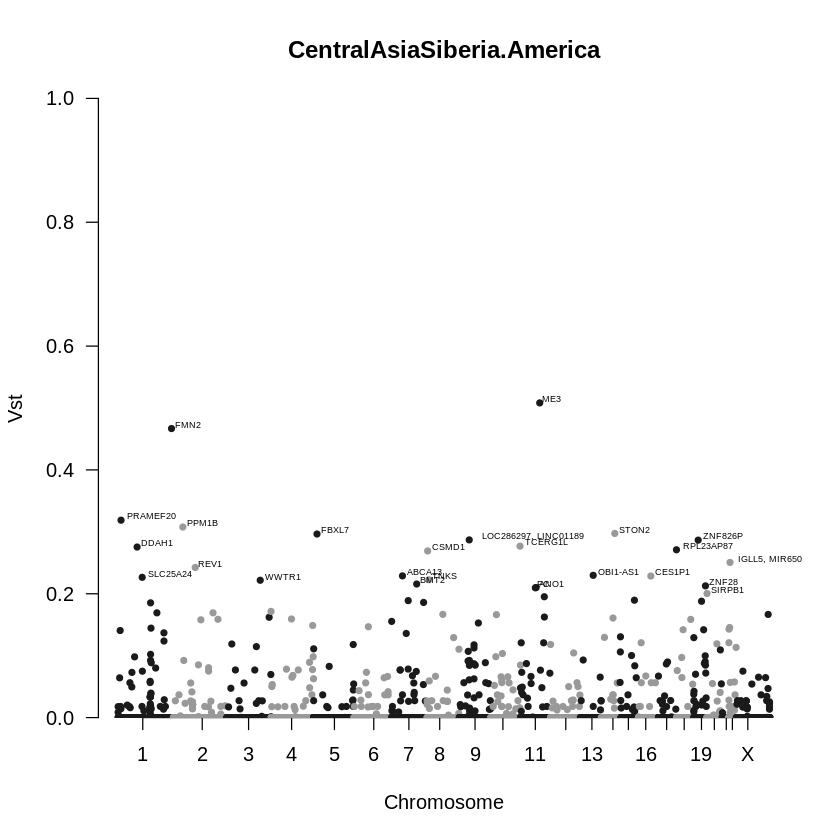

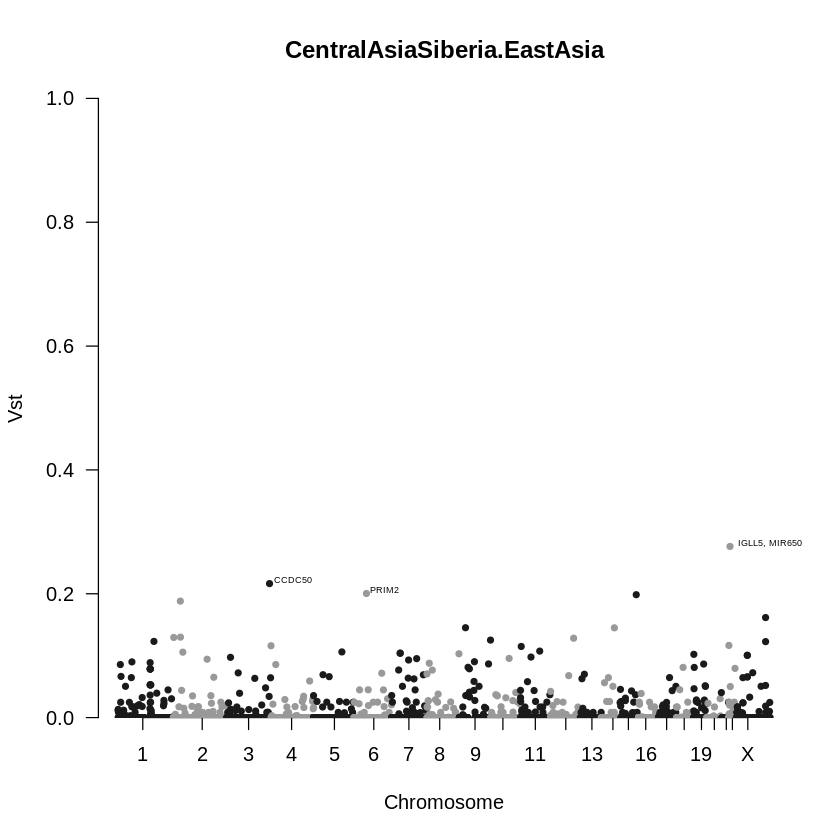

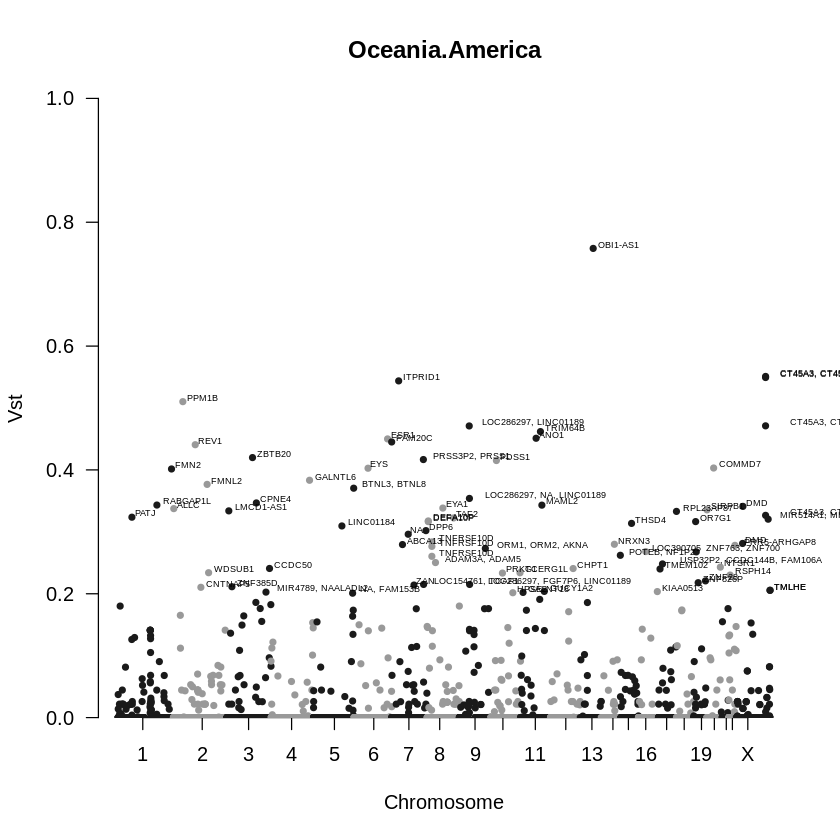

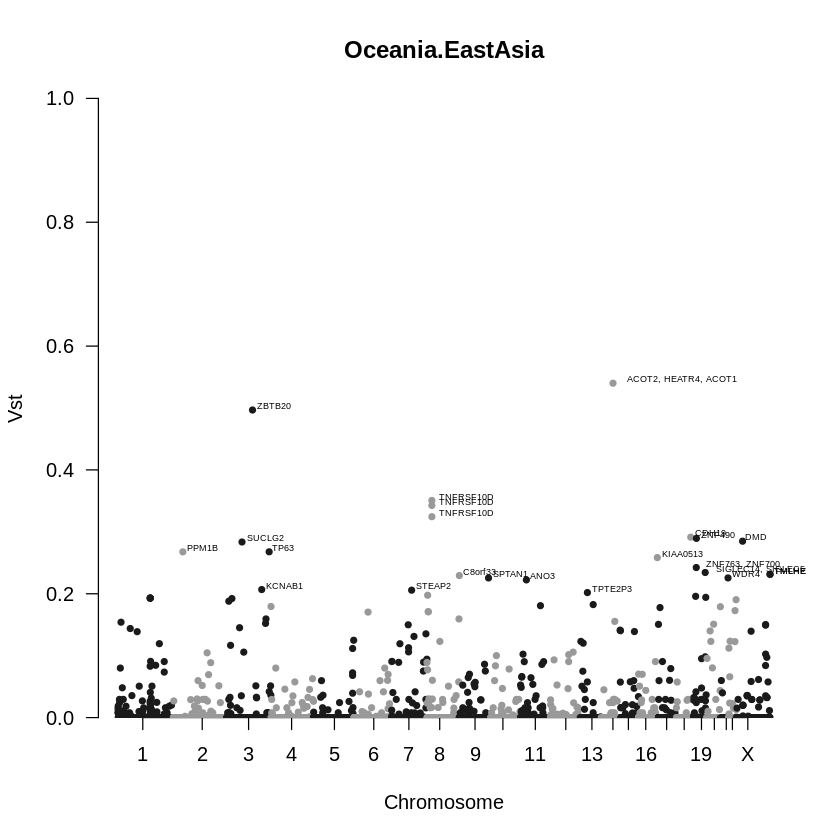

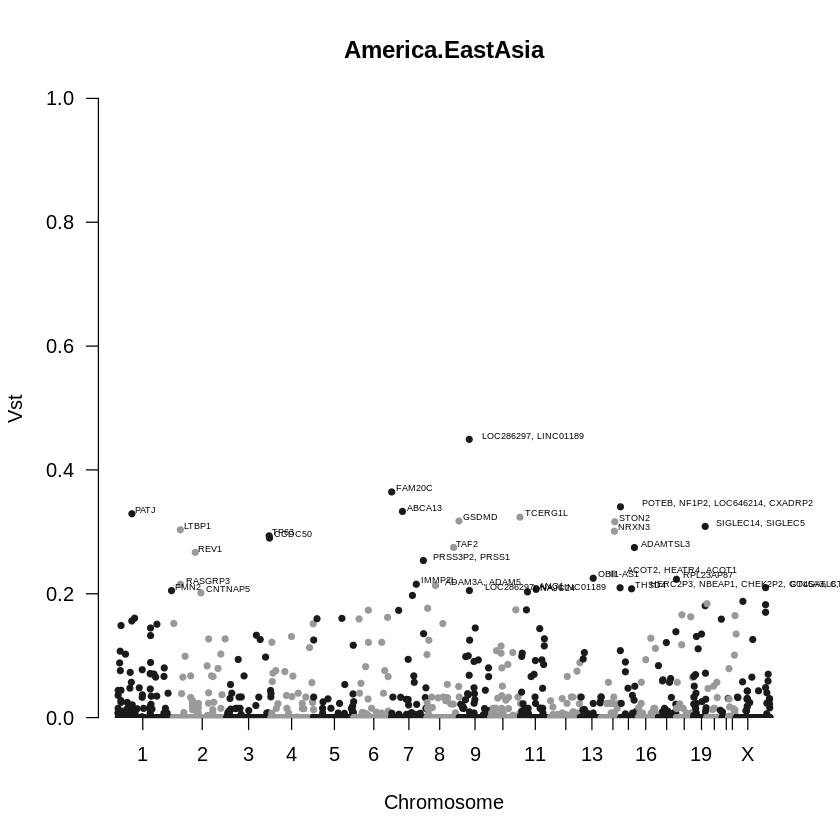

In [18]:
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst", chrlabs= c(1:22,"X")) 

}